In [1]:
import pandas as pd
import numpy as np
import pyreadr
import math
import random
import os
import csv

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

import os
import time

## Parte I

### Pregunta 1

| Marca – modelo | Precio ($) | Bus Memoria | Memoria | Velocidad de Boost (memoria) | Velocidad Game | Velocidad Bandwidth |
| --- | --- | --- | --- | --- | --- | --- |
| MSI Radeon  | 515 | 128 bits | 8GB GDDR6 | 2602 MHz | 2413 MHz |  | 
| RX 6600 XT |       |         |           |         |          |           |
| BIOSTAR RADEON RX560  | 515 | 128 bits | 4GB DDR5 | 1175 MHz | 1275MHz |  |
| PNY GEFORCE RTX 3060 | 550 | 192 bits | 12GB GDDR6 | 1777 MHz |  | 360 GB | 

Fuentes:
- https://cyccomputer.pe/amd-radeon/21256-msi-radeon-rx-6600-xt-mech-2x-8gb-gddr6-128bits-oc-pn912-v502-015.html
- https://cyccomputer.pe/amd-radeon/20821-biostar-radeon-rx560-4gb-ddr5-128bits-gaming-pnva5615rf41-tbhra-bs2.html
- https://cyccomputer.pe/nvidia-geforce-rtx/21359-pny-geforce-rtx-3060-12gb-gddr6-192bits-xlr8-gaming-oem-pngmr3061n4jcet1bktp.html

Para realizar computación en paralelo, la mejor opción a tomar en cuenta es la MSI Radeon; ya que, cuesta un poco menos que la PNY y tiene varias ventajas, entre estas se tiene que la MSI posee un mayor rendimiento en velocidad de reloj del procesador y de memoria GPU, a pesar de que se está sacrificando un poco de potencia en el procesamiento de la GPU, lo que permite un rendimiento superior para la ejecución de computación en paralelo. 

Por otra parte, la MSI supera en velocidad de la memoria a los otros modelos, con lo cual se incrementa el rendimiento en aplicaciones ya que tienen mayores registros de velocidad a diferencia de la PNY. También, se puede atribuir a ambas un similar funcionamiento de las tarjetas gráficas, ya que ambas poseen una misma anchura del bus de memoria, con lo cual tienen similar capacidad de soportar más datos por ciclo. Finalmente, se puede concluir que la MSI debería ser la tarjeta gráfica por elegir, ya que tiene un precio no muy distante de la PNY y tiene varias características a favor.


### Pregunta 2

Good Data no será reemplazado por Big Data o viceversa, ya que la estructura para obtener la información es diferente. Incluso en Couper (2013) se menciona que las nuevas formas de obtener data son interesantes, pero no se debe descartar los métodos tradicionales como las encuestas. Sin embargo, si se pueden complementar porque ambas forman parte de las herramientas que usa la ciencia de datos para inferir sobre la realidad. O como señala Ng (2022) se debería buscar tener datos de mejor calidad que partan por una selección basada en big data y las técnicas de IA correspondiente que permita mejorar la selección de pequeños datos.

Como ejemplo, se puede entender la información que proviene de las encuestas, ya que son una herramienta potente para levantar información y entender el mundo real, aunque no es la única herramienta. En Couper (2013) se llama una trampa a la idea de pensar que solo las encuestas nos ofrecen la mejor manera de recopilar información. De ahí resulta el Big Data y su facilidad para obtener los datos, los mismos que deben ser parte de un aprendizaje previo y ese redondeo al promedio conocido. Aplicado a la realidad que acabamos de pasar, es el uso de big data por el COVID-19, que finalmente dio lugar a Good data, pues permitió crear modelos de aprendizaje automático referente a trazabilidad del virus u otras aplicaciones de mejora de modelos epidemiológicos.

Otro ejemplo, las empresas en todo el mundo han desbordado sus bancos de datos y se han convertido en big data. Desde las cuentas de redes sociales hasta la cadena de suministro y los datos de gastos, las empresas tienen un acceso ilimitado. Pero con más información no necesariamente mejora la calidad del análisis, ya que la recopilación de datos es solo el primer paso. La gestión de datos, junto con el análisis de big data, lo ayudará a extraer los datos útiles y relevantes de las grandes cantidades de información disponible, y ponerlos en uso para generar valor y productividad para su negocio. Esto último es un claro ejemplo de good data.

### Pregunta 3

Al momento de importar nuestra base de datos, nuestras variables fueron importadas como de tipo 'O'. Inicialmente, tratamos de convertirlas en numéricas para poder realizar cálculos. Sin embargo, tuvimos dificultades realizando ello. Por ende, publicamos nuestro problema en Stackoverflow.

https://stackoverflow.com/questions/72828144/how-can-i-convert-an-object-variable-with-nan-into-an-int-variable-in-python

## Parte II

### Pregunta 1

### Pregunta 2

### Pregunta 3

### Pregunta 4

### Parte a

Primero, importamos los archivos archivos CSV que tenemos en la carpeta data

In [7]:
%%time 

# En folderpath, se debe cambia el path en donde se encuentren los archivos CSV
folderpath =  r"data"
print("Files and directories in a specified path:")
files = []
for filename in os.listdir(folderpath):
    f = os.path.join(folderpath, filename)
    files.append(f)
    if os.path.isfile(f):
        print(f)

Files and directories in a specified path:
data\endes_2021_programas_sociales_hogar.csv
data\endes_2021_RE223132.csv
data\endes_2021_RE516171.csv
data\endes_2021_RE758081.csv
data\endes_2021_REC84DV.csv
data\endes_2021_REC91.csv
data\endes_2021_REC93DVdisciplina.csv
data\endes_2021_REC95.csv
data\endes_2021_RECH23.csv
Wall time: 4.99 ms


#### Import csv using dask


In [4]:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster()  # Launches a scheduler and workers locally
client = Client(cluster)  # Connect to distributed cluster and override default
client

Client Scheduler: tcp://127.0.0.1:54276 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 8 Memory: 12.68 GB


In [5]:
import dask.dataframe as dd

In [8]:
#guardamos los dask dataframes en una lista
dfs = []

for file in files:
    
    df = dd.read_csv(file, dtype=str)
    dfs.append(df)

In [9]:
#asignamos nombres a los dataframes
programas_sociales = dfs[0]
nacimiento = dfs[1]
nupcialidad_fecundidad = dfs[2]
sida_condon = dfs[3]
mortalidad_violencia = dfs[4]
MEF = dfs[5] 
disciplina_infantil = dfs[6]
inmunizacion_salud = dfs[7]
vivienda = dfs[8]

In [10]:
# identificar bases que tengan CASEID
df_list = [programas_sociales, nacimiento, nupcialidad_fecundidad, sida_condon, mortalidad_violencia, MEF, disciplina_infantil,
          inmunizacion_salud,vivienda]

df_list_names = ["programas_sociales", "nacimiento", "nupcialidad_fecundidad", "sida_condon", "mortalidad_violencia", "MEF", "disciplina_infantil",
          "inmunizacion_salud","vivienda"]

df_CASEID = []

for df, df_name in zip(df_list,df_list_names):
       
    if 'CASEID' in df.columns:
        print(df_name)
        
        df_CASEID.append(df)

nacimiento
nupcialidad_fecundidad
sida_condon
mortalidad_violencia
MEF
disciplina_infantil
inmunizacion_salud


#### Merging dfs

In [11]:
base_total = nacimiento.merge(nupcialidad_fecundidad, on = ['CASEID', 'ID1'], how ='left').merge(sida_condon, on = ['CASEID', 'ID1'], how ='left').merge(mortalidad_violencia, on = ['CASEID', 'ID1'], how ='left').merge(MEF, on = ['CASEID', 'ID1'], how ='left').merge(disciplina_infantil, on = ['CASEID', 'ID1'], how ='left').merge(inmunizacion_salud, on = ['CASEID', 'ID1'], how ='left')

In [13]:
df_final = base_total.compute()

In [14]:
df_final.dtypes

ID1         object
CASEID      object
V201        object
V202        object
V203        object
             ...  
S466DC12    object
S466MC12    object
S466YC12    object
S466WC12    object
S466HC12    object
Length: 1272, dtype: object

In [15]:
%%time 

# Seleccionando las variables de interés 
variables = ['ID1', 'SREGION', 'SPROVIN', 'SDISTRI', 'CASEID',
             'S108N', 'S119', 'S119D', 'V218', 'V213', 'V225',    # carac. personales
             'S45D4', 'S45D5', 'S45P4', 'S45P5', 'S45B0',    # vacunas
             'S45B1', 'S45B2', 'S45B3', 'S45F1', 'S45F2',    # vacunas
             'V501', 'V714', 'D104', 'D106', 'D107', 'D108']

data_final = df_final[variables]
data_final.shape

Wall time: 673 ms


(43137, 27)

In [16]:
for i in variables:
        if data_final[i].dtype == 'O':
            data_final[i] = data_final[i].str.replace(" ", "")
            # Reemplazando los missing values por NaN
            data_final[i] = data_final[i].replace(' ', np.nan)

            # Convirtiendo los datos a valores numéricos
            data_final[i] =  np.floor(pd.to_numeric(data_final[i], errors='coerce').astype('Int64'))

In [17]:
data_final.dtypes

ID1        Float64
SREGION    Float64
SPROVIN    Float64
SDISTRI    Float64
CASEID     Float64
S108N      Float64
S119       Float64
S119D      Float64
V218       Float64
V213       Float64
V225       Float64
S45D4      Float64
S45D5      Float64
S45P4      Float64
S45P5      Float64
S45B0      Float64
S45B1      Float64
S45B2      Float64
S45B3      Float64
S45F1      Float64
S45F2      Float64
V501       Float64
V714       Float64
D104       Float64
D106       Float64
D107       Float64
D108       Float64
dtype: object

#### Creación de por lo menos dos variables

*Las variables de interés son las siguientes:*

D104: Hubo violencia emocional | 0=No, 1=Sí

D106: Experimentó cualquier violencia física menos severa | 0=No, 1=Sí

D107: Experimentó cualquier violencia física severa | 0=No, 1=Sí

D108: Experimentó cualquier violencia sexual | 0=No, 1=Sí



1) Creamos una variable que indique la cantidad de tipos de violencia (emocional, física menos severa, física severa, sexual) que la mujer ha sido víctima por parte de su esposo/compañero. Esta variable está en el rango de 0 a 4.

In [20]:
# Agregando los datos para evaluar cuántas mujeres han sido víctimas de violencia en al menos una de sus modalidades
data_final['violencia'] = data_final['D104'] + data_final['D106'] + data_final['D107'] + data_final['D108']

2) Creamos una variable dicotómica que indique si es que la mujer ha sido víctima de, al menos, un tipo de violencia por parte de su esposo/compañero

In [21]:
# Creando variable dummy 
data_final['y'] = data_final['violencia']
data_final.loc[(data_final['y'] > 0), 'y'] = 1

#### Dos estadísticos descriptivos 

In [39]:
tab1 = data_final['violencia'].value_counts().to_frame().reset_index()
tab1.rename(columns = {'index':'n_violencia', 'violencia':'n_casos'}, inplace = True)
tab1['n_violencia'] = tab1['n_violencia'].astype(int)

tab1['%'] = round( (tab1['n_casos']/sum(tab1.n_casos))*100 , 2)
tab1

,n_violencia,n_casos,%
0,0,18395,66.16
1,1,4372,15.72
2,2,2621,9.43
3,3,1598,5.75
4,4,817,2.94


Se observa que el 66.16% de mujeres no sufren ningún tipo de violencia por parte de su esposo/compañero. Sin embargo, hay un 15.72% de mujeres que sufren 1 tipo de violencia. Se encuentra que solo el 2.94% de mujeres sufren los 4 tipos de violencia.

In [42]:
tab2 = data_final['y'].value_counts().to_frame().reset_index()
tab2.rename(columns = {'index':'d_violencia', 'y':'n_casos'}, inplace = True)
tab2['d_violencia'] = tab2['d_violencia'].astype(int)

tab2['%'] = round( (tab2['n_casos']/sum(tab2.n_casos))*100 , 2)
tab2

,d_violencia,n_casos,%
0,0,18395,66.16
1,1,9408,33.84


Se encuentra que un 33.84% de las mujeres de la muestra sufren de, al menos, algún tipo de violencia por parte de su esposo/compañero.

#### Gráficos

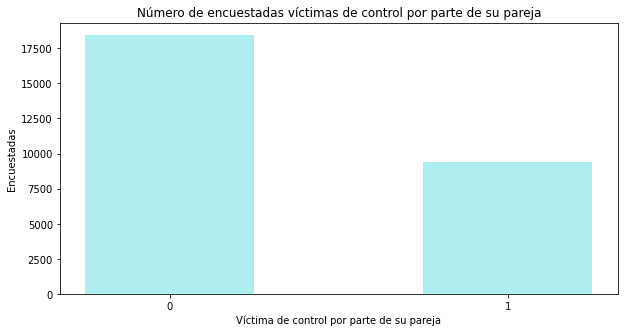

In [44]:
tab_plot=tab2.rename(columns = {'d_violencia':'Victima_control_pareja', 'n_casos':'Total'})
tab_plot['Victima_control_pareja'] = tab_plot.Victima_control_pareja.astype(str)


fig = plt.figure(figsize = (10, 5))
#  Bar plot
plt.bar(tab_plot['Victima_control_pareja'], tab_plot['Total'], color ='paleturquoise',
        width = 0.5)
plt.xlabel("Víctima de control por parte de su pareja")
plt.ylabel("Encuestadas")
plt.title("Número de encuestadas víctimas de control por parte de su pareja")
plt.show()

In [61]:
tot_D106 = data_final.groupby('D106')['D106'].count()
tot_D106=tot_D106.rename(None).to_frame().reset_index()
tot_D106.columns=['Victima','Violencia_menos_severa']

tot_D107 = data_final.groupby('D107')['D107'].count()
tot_D107=tot_D107.rename(None).to_frame().reset_index()
tot_D107.columns=['Victima','Violencia_severa']

tot_D108 = data_final.groupby('D108')['D108'].count()
tot_D108=tot_D108.rename(None).to_frame().reset_index()
tot_D108.columns=['Victima','Violencia_sexual']

tab_plot = pd.merge(tot_D106, tot_D107, on='Victima', how='left')
tab_plot = pd.merge(tab_plot, tot_D108, on='Victima', how='left')
tab_plot['Victima'] = tab_plot.Victima.astype(str)

tab_plot = tab_plot.set_index('Victima')

In [62]:
tab_plot

,Violencia_menos_severa,Violencia_severa,Violencia_sexual
Victima,,,
0.0,20445,25303,26244
1.0,7358,2500,1559


Text(0, 0.5, 'Experimentó violencia')

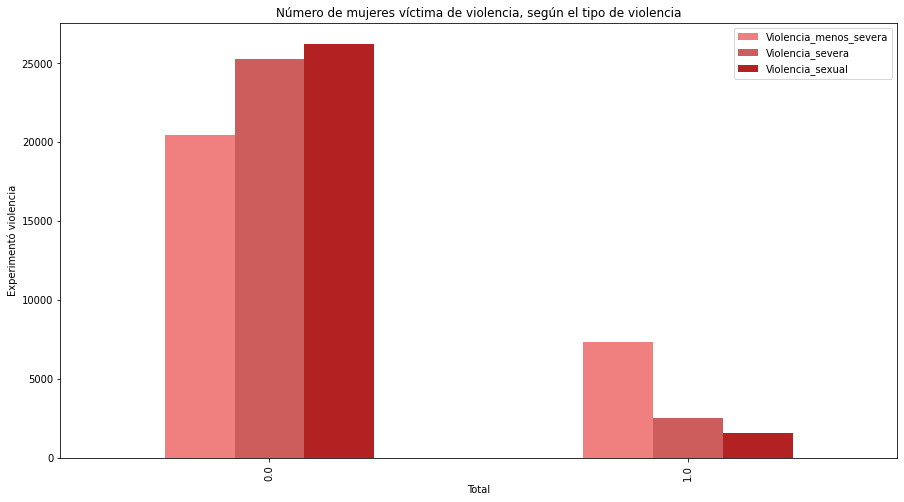

In [63]:
tab_plot.plot(kind="bar",figsize=(15, 8), color = ['lightcoral','indianred','firebrick'])

plt.title("Número de mujeres víctima de violencia, según el tipo de violencia")

plt.xlabel("Total")

plt.ylabel("Experimentó violencia")

### Parte b

In [70]:
data_final.columns

Index(['ID1', 'SREGION', 'SPROVIN', 'SDISTRI', 'CASEID', 'S108N', 'S119',
       'S119D', 'V218', 'V213', 'V225', 'S45D4', 'S45D5', 'S45P4', 'S45P5',
       'S45B0', 'S45B1', 'S45B2', 'S45B3', 'S45F1', 'S45F2', 'V501', 'V714',
       'D104', 'D106', 'D107', 'D108', 'violencia', 'y'],
      dtype='object')

#### Definición de predictores (X) y vector de target (y)

In [91]:
# Printeamos qué tipo de variable es cada columna sin considerar a los identificadores (ID1, CASEID)
for col in data_final:
    if col != 'ID1' and col != 'CASEID':
        print(f"{col}:", data_final[col].dtypes )

SREGION: category
SPROVIN: category
SDISTRI: Float64
S108N: Float64
S119: Float64
S119D: Float64
V218: Float64
V213: Float64
V225: Float64
S45D4: Float64
S45D5: Float64
S45P4: Float64
S45P5: Float64
S45B0: Float64
S45B1: Float64
S45B2: Float64
S45B3: Float64
S45F1: Float64
S45F2: Float64
V501: Float64
V714: Float64
D104: Float64
D106: Float64
D107: Float64
D108: Float64
violencia: Float64
y: Float64


In [79]:
for col in data_final:
    if col != 'ID1' and col != 'CASEID':
        print(f"{col}:", )
        print(data_final[col].value_counts())

SREGION: type
3.0    14068
2.0    12699
4.0    10856
1.0     5514
Name: SREGION, dtype: Int64
SPROVIN: type
1.0     21932
2.0      4263
3.0      3738
6.0      2359
7.0      2088
5.0      2036
8.0      1638
4.0      1526
9.0      1091
18.0      661
10.0      595
11.0      584
12.0      350
13.0      164
20.0       59
15.0       39
16.0       14
Name: SPROVIN, dtype: Int64
SDISTRI: type
1.0     13921
2.0      3419
4.0      2863
5.0      2857
3.0      2705
6.0      2664
7.0      2167
10.0     2026
8.0      1770
9.0      1202
12.0     1083
11.0      826
13.0      772
14.0      522
32.0      499
15.0      425
17.0      380
35.0      379
16.0      282
19.0      252
18.0      214
33.0      214
25.0      211
43.0      182
42.0      176
37.0      140
20.0      137
28.0      129
22.0      114
23.0      111
29.0       94
21.0       77
40.0       56
36.0       48
31.0       43
26.0       41
30.0       40
34.0       28
24.0       27
39.0       21
41.0       20
Name: SDISTRI, dtype: Int64
S108N: typ

In [97]:
categorical_vars = ['SREGION', 'S108N', 'S119', 'S119D', 'V213', 'V225', 'S119', 'V501', 'V714'] 

integer_vars = ['V218']

In [95]:
#convertimos las variables que deberian ser categóricas en "category"
for col in categorical_vars:
    data_final[col] = data_final[col].astype('category',copy=False)

In [115]:
for col in categorical_vars:
    print(data_final[col].value_counts())

sierra    14068
Costa     12699
selva     10856
Lima       5514
Name: SREGION, dtype: int64
secundaria           21139
primaria              8982
universitario         6419
no_universitarrio     5643
ninguno                591
postgrado              363
Name: S108N, dtype: int64
10.0                  34581
nativo                 7742
9.0                     305
no_universitar<rio      227
postgrado               165
6.0                      43
11.0                     30
12.0                     24
7.0                      10
8.0                      10
Name: S119, dtype: int64
7.0     18437
1.0     11784
5.0      4960
6.0      3061
98.0     2118
2.0      1280
3.0       949
8.0       385
4.0       163
Name: S119D, dtype: int64
0.0    41940
1.0     1197
Name: V213, dtype: int64
2.0    501
1.0    436
3.0    260
Name: V225, dtype: int64
10.0                  34581
nativo                 7742
9.0                     305
no_universitar<rio      227
postgrado               165
6.0           

In [114]:
#colocandole labels a las variables categóricas para mayor entendimiento

#región natural:
data_final.SREGION.replace({1.0:'lima', 2.0: 'costa', 3.0:'sierra',4.0:'selva'}, inplace = True)

#nivel educativo:
data_final.S108N.replace({0.0:'ninguno', 1.0: 'primaria', 2.0:'secundaria',3.0:'superior',4.0:'superior',5.0:'superior'}, inplace = True)

#lengua materna:
data_final.S119.replace({1.0:'nativo', 2.0: 'nativo', 3.0:'nativo',4.0:'nativo',5.0:'nativo',6.0:'nativo', 7.0:'nativo', 8.0:'nativo', 9.0:'nativo', 10.0:'castellano', 11.0:'extranjero', 12.0:'extranjero'}, inplace = True)

#lengua materna:


In [105]:
data_final.SREGION

0        3.0
1        3.0
2        3.0
3        3.0
4        3.0
        ... 
43132    4.0
43133    4.0
43134    4.0
43135    4.0
43136    4.0
Name: SREGION, Length: 43137, dtype: category
Categories (4, Float64): [1.0, 2.0, 3.0, 4.0]

In [96]:
for col in data_final:
    if col != 'ID1' and col != 'CASEID':
        print(f"{col}:", data_final[col].dtypes )

SREGION: category
SPROVIN: category
SDISTRI: Float64
S108N: category
S119: category
S119D: category
V218: Float64
V213: category
V225: category
S45D4: Float64
S45D5: Float64
S45P4: Float64
S45P5: Float64
S45B0: Float64
S45B1: Float64
S45B2: Float64
S45B3: Float64
S45F1: Float64
S45F2: Float64
V501: category
V714: category
D104: Float64
D106: Float64
D107: Float64
D108: Float64
violencia: Float64
y: Float64
